### Note: <br>
This code for the fine-tuning process of XLNet for hate speech detection is based on the following example, published on Medium: <br>

link to article: https://medium.com/swlh/using-xlnet-for-sentiment-classification-cfa948e65e85 <br>
author: Shanay Ghag <br>
published at: Jun 16, 2020<br>
link to GitHub: https://github.com/shanayghag/Sentiment-classification-using-XLNet

In [1]:
from datasets import load_dataset_builder, load_dataset
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import re

import sentencepiece
from collections import defaultdict
import random
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler, Dataset, DataLoader
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
# set up connection to drive: 
#from google.colab import drive
#drive.mount('/content/drive')

# define device: 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def prepare_text(text):
    text = re.sub(r"@[A-Za-z0-9_]+", ' ', text) # remove @user 
    text = re.sub(r"https?://[A-Za-z0-9./]+", ' ', text) # remove links
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text) # remove smileys
    text = re.sub('#', '', text) # remove hash sign
    text = re.sub('\t', ' ',  text) # remove tab
    text = re.sub(r" +", ' ', text) # remove multiple whitespaces
    return text

# 1. Prepare Hate Dataset for Fine-Tuning

In [4]:
# Load HateXplain dataset
import json
f = open('../input/hatexplain-dataset/HateXplain_dataset.json')
ds_json = json.load(f)

In [5]:
from collections import Counter

for key in ds_json.keys():
    annotators = ds_json[key]['annotators']
    slst = [ele['label'] for ele in annotators]
    words_count = Counter(slst)
    if words_count['normal'] >= 2:
        label_word = 'normal'
        label = 0
    elif words_count['offensive'] >= 2:
        label_word = 'offensive'
        label = 1
    elif words_count['hatespeech'] >= 2:
        label_word = 'hatespeech'
        label = 1
    else:
        label_word = "undecided"
        label = 1 # put it into category one since in the paper hatespeech and offensive fell into the hate category
    ds_json[key]['label'] = label
    ds_json[key]['label_word'] = label_word
    ds_json[key]['text'] = " ".join(ds_json[key]['post_tokens'])

In [6]:
df_hatexplain = pd.DataFrame(ds_json).transpose()
df_testing = df_hatexplain.loc[:,['text', 'label']]
df_testing = df_testing[:20000]
df_testing['text'] = df_testing['text'].apply(prepare_text)

In [7]:
len(df_testing)

20000

In [8]:
# custom dataset class
class HateDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(review,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              truncation=True,
                                              return_token_type_ids=False,
                                              pad_to_max_length=False,
                                              return_attention_mask=True,
                                              return_tensors='pt',)
        
        input_ids = pad_sequences(encoding['input_ids'], 
                                  maxlen=self.max_len, 
                                  dtype=torch.Tensor ,
                                  truncating="post",
                                  padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 
        
        attention_mask = pad_sequences(encoding['attention_mask'], 
                                       maxlen=self.max_len, 
                                       dtype=torch.Tensor ,
                                       truncating="post",
                                       padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       
        
        return {'review_text': review,
                'input_ids': input_ids,
                'attention_mask': attention_mask.flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [9]:
# define custom dataloader:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = HateDataset(reviews=df.text.to_numpy(),
                     targets=df.label.to_numpy(),
                     tokenizer=tokenizer,
                     max_len=max_len)
    
    return DataLoader(ds,
                    batch_size=batch_size,
                    num_workers=2)       

In [10]:
# define evaluation function:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].reshape(8,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]
            
            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)
            
            acc += accuracy
            losses.append(loss.item())
            counter += 1
            
    return acc / counter, np.mean(losses)

In [11]:
from transformers import XLNetForSequenceClassification, XLNetTokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
# read model saved in previous step:
# when connected to GPU:

model.load_state_dict(torch.load('../input/hate-classification-model/xlnet_model_hate.bin'))

# when not connected to GPU (hence no cuda):
#model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/models/xlnet_model_hate.bin', map_location=torch.device('cpu')))

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

<All keys matched successfully>

In [12]:
model = model.to(device)

In [13]:
test_data_loader = create_data_loader(df_testing, tokenizer, 512, 8)

In [14]:
# call evaluation function and apply to test set
'''
test_acc, test_loss = eval_model(model,
                                 test_data_loader,
                                 device,
                                 len(df_testing))

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)'''

"\ntest_acc, test_loss = eval_model(model,\n                                 test_data_loader,\n                                 device,\n                                 len(df_testing))\n\nprint('Test Accuracy :', test_acc)\nprint('Test Loss :', test_loss)"

In [15]:
# define function to get prediction of data
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].reshape(8,512).to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids,
                            token_type_ids=None,
                            attention_mask=attention_mask,#
                            labels=targets)
            
            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)
            probs = F.softmax(outputs[1], dim=1)
            review_texts.extend(texts)
            threshold = 0.99
            pred_thresh = []
            for i in probs:
                hatespeech_prob = i[1]
                if hatespeech_prob < threshold:
                    pred_thresh.append(0)
                elif hatespeech_prob >= threshold:
                    pred_thresh.append(1)
            predictions.extend(torch.tensor(pred_thresh))
            prediction_probs.extend(probs)
            real_values.extend(targets)
            
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    
    return review_texts, predictions, prediction_probs, real_values

In [16]:
# call prediction function to get actual predictions of test set 
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [17]:
class_names = ['no hate', 'hate']
print(classification_report(y_test, y_pred, target_names=class_names))
report = classification_report(y_test, y_pred, target_names=class_names,output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv('report_hate.csv')

              precision    recall  f1-score   support

     no hate       0.51      0.63      0.56      7778
        hate       0.72      0.62      0.67     12222

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.64      0.62      0.63     20000



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


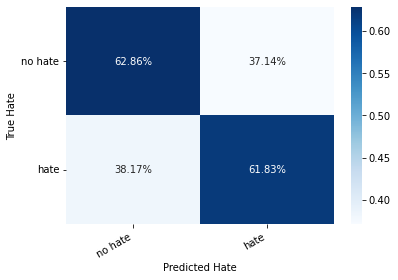

In [18]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix/ confusion_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

    plt.ylabel('True Hate')
    plt.xlabel('Predicted Hate')
    plt.savefig('confusion_hate');
    

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.to_csv('cm_hate.csv')

show_confusion_matrix(df_cm)